In [3]:
!python validation.py

python3: can't open file '/content/validation.py': [Errno 2] No such file or directory


In [4]:
!pip install requests networkx tqdm

In [23]:
!pip install matplotlib

In [5]:
import os

BASE_PATH = "/content/forense_data/"
os.makedirs(BASE_PATH, exist_ok=True)

print("Pasta criada em:", BASE_PATH)

Pasta criada em: /content/forense_data/


In [6]:
import os
import time
import json
import re
import requests
import numpy as np
from collections import Counter

In [7]:
EXCLUDE = [
    '1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s',
    '1HaTSjMb9Tg8yDNk5axvnWqyTUss26XUjV'
]

def pega_endereco(endereco, path_local=BASE_PATH):
    if endereco in EXCLUDE:
        return None

    if not re.match(r"^(1|bc1)", endereco):
        return None

    filename = os.path.join(path_local, f"{endereco}.json")

    if os.path.exists(filename):
        with open(filename, "r") as f:
            return json.load(f)

    try:
        url = f"https://blockchain.info/rawaddr/{endereco}"
        r = requests.get(url)
        if r.status_code == 200:
            data = r.json()
            with open(filename, "w") as f:
                json.dump(data, f)
            time.sleep(5)  # MUITO IMPORTANTE
            return data
        else:
            print("Erro HTTP:", r.status_code)
    except Exception as e:
        print("Erro:", e)

    return None

In [8]:
TARGET = "1JHH1pmHujcVa1aXjRrA13BJ13iCfgfBqj"

addr_info = pega_endereco(TARGET)

print("Total de transações:", addr_info["n_tx"])
print("Total recebido (BTC):", addr_info["total_received"] / 1e8)

Total de transações: 709
Total recebido (BTC): 3930.70485283


In [9]:
def extrai_depositos(addr_info, target):
    valores = []
    depositantes = set()
    transacoes_deposito = []

    for tx in addr_info.get("txs", []):
        is_deposito = False

        for out in tx.get("out", []):
            if out.get("addr") == target:
                valores.append(out["value"] / 1e8)
                is_deposito = True

        if is_deposito:
            transacoes_deposito.append(tx)
            for inp in tx.get("inputs", []):
                prev = inp.get("prev_out", {})
                a = prev.get("addr")
                if a:
                    depositantes.add(a)

    return valores, depositantes, transacoes_deposito

In [10]:
valores, depositantes, tx_deposito = extrai_depositos(addr_info, TARGET)

print("Número de depósitos:", len(valores))
print("Número de depositantes únicos:", len(depositantes))

Número de depósitos: 50
Número de depositantes únicos: 60


In [11]:
def estatisticas_basicas(valores):
    v = np.array(valores)
    return {
        "total": float(v.sum()),
        "media": float(v.mean()),
        "min": float(v.min()),
        "max": float(v.max()),
        "n": len(v)
    }

stats = estatisticas_basicas(valores)
stats

{'total': 3207.20774417,
 'media': 64.14415488339999,
 'min': 0.06568482,
 'max': 650.0,
 'n': 50}

In [12]:
def gini(x):
    x = np.array(x)
    x = x[x > 0]
    x.sort()
    n = len(x)
    return (2 * np.sum((np.arange(1, n+1) * x))) / (n * np.sum(x)) - (n + 1) / n

gini_val = gini(valores)
print("Gini:", gini_val)

Gini: 0.7941377616247101


In [13]:
def benford(valores):
    digitos = [str(v)[0] for v in valores if v > 0]
    return Counter(digitos)

ben = benford(valores)
ben

Counter({'2': 4, '5': 2, '1': 8, '3': 3, '8': 2, '6': 1, '9': 1, '0': 29})

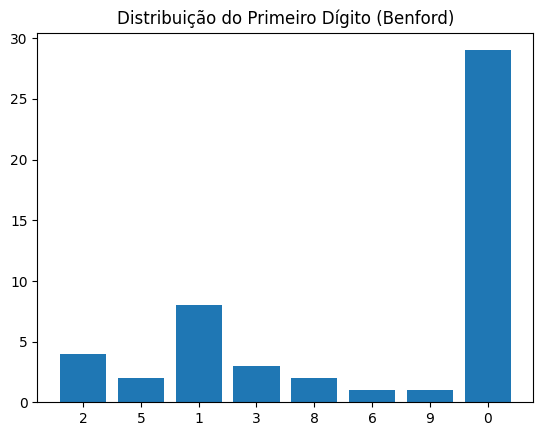

In [14]:
import matplotlib.pyplot as plt

plt.bar(ben.keys(), ben.values())
plt.title("Distribuição do Primeiro Dígito (Benford)")
plt.show()

In [15]:
def cluster_h1(transacoes):
    clusters = []

    for tx in transacoes:
        ins = set()
        for i in tx.get("inputs", []):
            addr = i.get("prev_out", {}).get("addr")
            if addr and re.match(r"^(1|bc1)", addr):
                ins.add(addr)

        if len(ins) > 1:
            clusters.append(ins)

    return clusters

clusters_h1 = cluster_h1(tx_deposito)
print("Clusters H1 encontrados:", len(clusters_h1))

Clusters H1 encontrados: 13


In [16]:
def identifica_troco(tx, target_addr):
    outs = tx.get("out", [])
    if len(outs) != 2:
        return None

    for out in outs:
        addr = out.get("addr")
        if addr and addr != target_addr:
            info = pega_endereco(addr)
            if info and info.get("n_tx") <= 2:
                return addr
    return None

In [17]:
trocos = []

for tx in tx_deposito:
    t = identifica_troco(tx, TARGET)
    if t:
        trocos.append(t)

print("Endereços de troco identificados:", len(trocos))

Endereços de troco identificados: 45
